In [1]:
!pip install kaggle
!pip install -U datasets
!pip install transformers
!pip install torch torchvision
!pip install pillow
!pip install matplotlib
!pip install scikit-learn
!pip install accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, DatasetDict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os
from google.colab import files

In [3]:

# Download dataset

# Please upload your kaggle.json file
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download and unzip data file
!kaggle d download -q adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal
!unzip -q air-pollution-image-dataset-from-india-and-nepal.zip \
"Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP/*"

!mv "Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP" .
!mv IND_and_NEP IMAGES
!rm -r "Air Pollution Image Dataset/" air-pollution-image-dataset-from-india-and-nepal.zip
# Check dataset structure
print("Dataset classes:", os.listdir("IMAGES"))




Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
Dataset classes: ['f_Severe', 'e_Very_Unhealthy', 'a_Good', 'b_Moderate', 'd_Unhealthy', 'c_Unhealthy_for_Sensitive_Groups']


In [3]:
# Load dataset using Hugging Face datasets
dataset = load_dataset("imagefolder", data_dir="IMAGES")

Resolving data files:   0%|          | 0/12240 [00:00<?, ?it/s]

In [4]:
# Shuffle and split dataset
dataset = dataset.shuffle(seed=42)
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Split training set to create validation set
train_test_split = dataset['train'].train_test_split(test_size=0.25, seed=42)  # 0.25 * 0.8 = 0.2 validation
dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
    'test': dataset['test']
})

print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

Train samples: 7344
Validation samples: 2448
Test samples: 2448


In [5]:
class_names = dataset['train'].features['label'].names

In [6]:
"""## Vision Transformer Setup"""

# Initialize ViT model and processor
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

# Get number of classes from dataset
num_classes = len(dataset['train'].features['label'].names)
class_names = dataset['train'].features['label'].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Load pre-trained ViT model and modify for our number of classes
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    id2label={i: class_name for i, class_name in enumerate(class_names)},
    label2id={class_name: i for i, class_name in enumerate(class_names)}
)
"""## Data Preprocessing"""

def transform_images(examples):
    """Transform images using ViT processor"""
    # Convert images to RGB if they aren't already
    images = [img.convert('RGB') if img.mode != 'RGB' else img for img in examples['image']]

    # Process images using ViT processor
    inputs = processor(images, return_tensors="pt")
    inputs['labels'] = torch.tensor(examples['label'])

    return inputs

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    return {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

# Apply transformations to datasets
train_dataset = dataset['train'].with_transform(transform_images)
val_dataset = dataset['validation'].with_transform(transform_images)
test_dataset = dataset['test'].with_transform(transform_images)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of classes: 6
Class names: ['a_Good', 'b_Moderate', 'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./vit-air-pollution',
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",  # Try this instead of evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",  # Disable wandb logging
)

# Define metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.433200,1.365834,0.633170
2,0.707100,0.673087,0.888889
3,0.342500,0.358095,0.933415
4,0.175400,0.171028,0.975490
5,0.153100,0.117661,0.979167
6,0.051600,0.079819,0.988971
7,0.040600,0.065266,0.989788
8,0.027800,0.047758,0.993873
9,0.025200,0.047498,0.993056
10,0.023900,0.046730,0.993056


Evaluating on test set...


Accuracy: 0.9931

Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.99      1.00      1.00       305
                      b_Moderate       1.00      0.99      0.99       298
c_Unhealthy_for_Sensitive_Groups       1.00      0.99      0.99       589
                     d_Unhealthy       0.99      1.00      0.99       499
                e_Very_Unhealthy       0.99      0.99      0.99       453
                        f_Severe       0.99      1.00      1.00       304

                        accuracy                           0.99      2448
                       macro avg       0.99      0.99      0.99      2448
                    weighted avg       0.99      0.99      0.99      2448



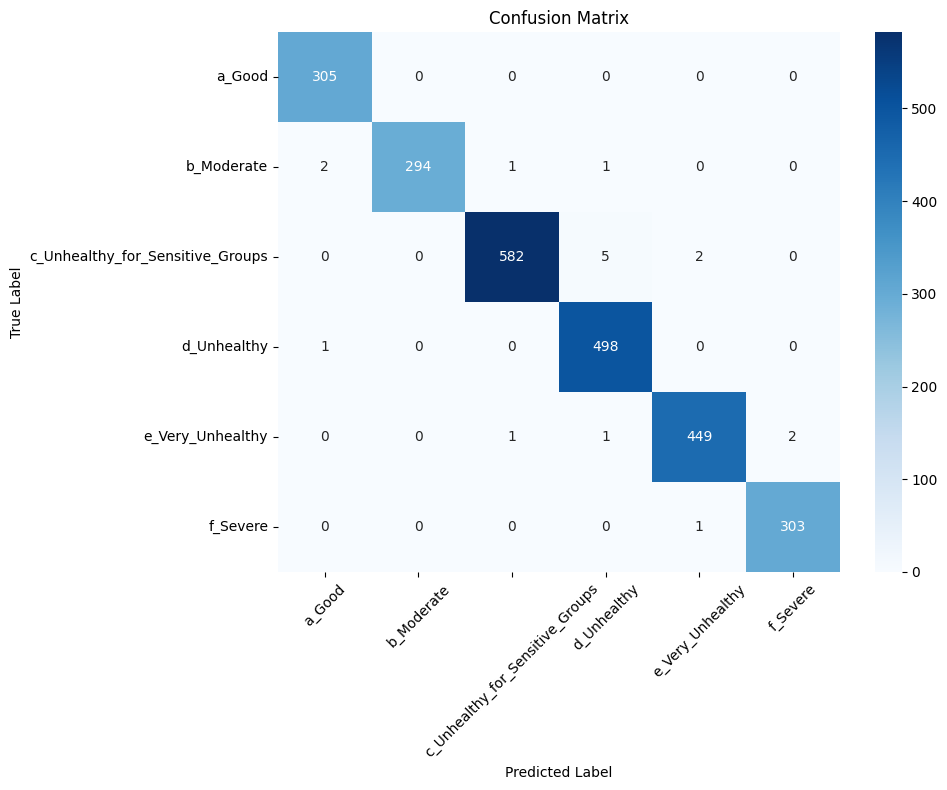

Sample predictions on test set:


TypeError: Wrong key type: '2098' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

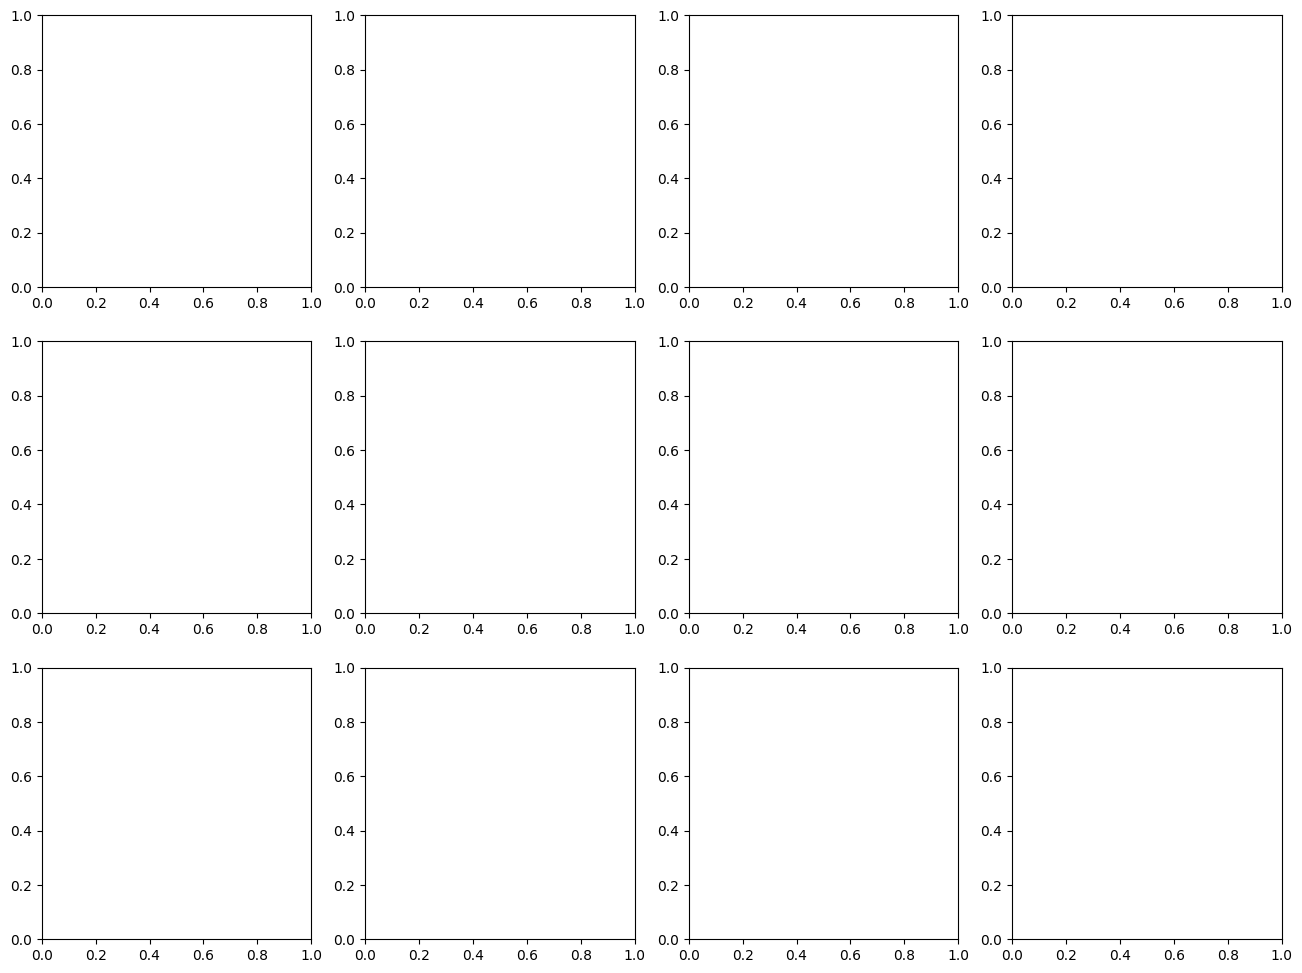

In [13]:
"""## Model Training"""

print("Starting training...")
trainer.train()

# Save the best model
trainer.save_model('./best_vit_model')
processor.save_pretrained('./best_vit_model')
"""## Model Evaluation"""

def evaluate_model(model, dataset, class_names):
    """Evaluate model performance"""
    model.eval()
    all_predictions = []
    all_labels = []

    # Use trainer for prediction to handle batching properly
    predictions = trainer.predict(dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy, predicted_labels, true_labels
  # Evaluate on test set
print("Evaluating on test set...")
test_accuracy, test_predictions, test_labels = evaluate_model(model, test_dataset, class_names)

"""## Visualization and Analysis"""
def plot_sample_predictions(dataset, predictions, true_labels, class_names, num_samples=12):
    """Plot sample predictions with true and predicted labels"""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    # Get random sample indices
    sample_indices = np.random.choice(len(predictions), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Get image
        image = dataset[idx]['image']
        if isinstance(image, torch.Tensor):
            # If tensor, convert to PIL Image
            image = transforms.ToPILImage()(image)

        true_label = class_names[true_labels[idx]]
        pred_label = class_names[predictions[idx]]

        # Display image
        axes[i].imshow(image)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample predictions
print("Sample predictions on test set:")
plot_sample_predictions(dataset['test'], test_predictions, test_labels, class_names)

"""## Training History Visualization"""

def plot_training_history(trainer):
    """Plot training and validation metrics"""
    log_history = trainer.state.log_history

    train_loss = []
    eval_loss = []
    eval_accuracy = []

    for log in log_history:
        if 'loss' in log and 'eval_loss' not in log:
            train_loss.append(log['loss'])
        elif 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
            eval_accuracy.append(log['eval_accuracy'])

    epochs = range(1, len(eval_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(epochs, eval_loss, 'b-', label='Validation Loss')
    if len(train_loss) >= len(eval_loss):
        # Sample training loss to match evaluation epochs
        sampled_train_loss = [train_loss[i * len(train_loss) // len(eval_loss)] for i in range(len(eval_loss))]
        ax1.plot(epochs, sampled_train_loss, 'r-', label='Training Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(epochs, eval_accuracy, 'g-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(trainer)

"""## Model Inference Function"""

def predict_single_image(image_path_or_pil, model, processor, class_names):
    """Predict air pollution level for a single image"""
    # Load image
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil).convert('RGB')
    else:
        image = image_path_or_pil.convert('RGB')

    # Process image
    inputs = processor(image, return_tensors="pt")

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class_idx = predictions.argmax().item()
        confidence = predictions.max().item()

    predicted_class = class_names[predicted_class_idx]

    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.3f}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Example usage of prediction function
print("Testing single image prediction:")
# Use a random test image
test_idx = 0
test_image = dataset['test'][test_idx]['image']
true_label = class_names[dataset['test'][test_idx]['label']]
print(f"True label: {true_label}")

predicted_class, confidence = predict_single_image(test_image, model, processor, class_names)
print(f"Predicted: {predicted_class}, Confidence: {confidence:.3f}")

"""## Model Performance Summary"""

print("="*50)
print("VISION TRANSFORMER MODEL SUMMARY")
print("="*50)
print(f"Dataset: Air Pollution Images from India and Nepal")
print(f"Model: Vision Transformer (ViT-base-patch16-224)")
print(f"Number of classes: {num_classes}")
print(f"Class names: {', '.join(class_names)}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("="*50)

# Save final results
results = {
    'model_type': 'Vision Transformer',
    'test_accuracy': test_accuracy,
    'num_classes': num_classes,
    'class_names': class_names,
    'training_args': training_args.to_dict()
}

import json
with open('vit_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to vit_results.json")
print("Model saved to ./best_vit_model/")